<a href="https://colab.research.google.com/github/yhussain1/MachineLearning/blob/main/YuGiOhDescDeep1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
nltk.download(['all'])
from nltk.tokenize import sent_tokenize, word_tokenize
import random

In [2]:
from google.colab import files
upload_file = files.upload()

Saving ygocards.csv to ygocards.csv


In [3]:
df = pd.read_csv("ygocards.csv", delimiter = ',')
df.head()

emonster = ['Effect Monster', 'Spirit Monster', 'Tuner Monster', 'Gemini Monster', 'Toon Monster'] 
nmonster = ['Normal Monster']

df.loc[df['CardType'].str.contains('|'.join(nmonster)), 'CardType'] = 'Normal Monster'
df.loc[df['CardType'].str.contains('|'.join(emonster)), 'CardType'] = 'Effect Monster'
df.loc[df['CardType'].str.contains('Fusion'), 'CardType'] = 'Fusion Monster'
df.loc[df['CardType'].str.contains('Synchro'), 'CardType'] = 'Synchro Monster'
df.loc[df['CardType'].str.contains('Ritual'), 'CardType'] = 'Effect Monster'
df.loc[df['CardType'].str.contains('XYZ'), 'CardType'] = 'XYZ Monster'
df.loc[df['CardType'].str.contains('Link'), 'CardType'] = 'Link Monster'

df.loc[df['CardType'].str.contains('Token'), 'CardType'] = 'Token'
df.loc[df['CardType'].str.contains('Spell'), 'CardType'] = 'Spell'
df.loc[df['CardType'].str.contains('Trap'), 'CardType'] = 'Trap'
df.loc[df['CardType'].str.contains('Skill'), 'CardType'] = 'Spell'
df.drop(df[df.CardType == 'Token'].index, inplace = True)

df.head()
df = df.sample(frac=1)
df['CardType'].value_counts()

Effect Monster     4783
Spell              1852
Trap               1523
Normal Monster      517
XYZ Monster         388
Fusion Monster      334
Synchro Monster     306
Link Monster        275
Name: CardType, dtype: int64

In [4]:
df.shape

(9978, 3)

In [5]:
nm = df[df.CardType == 'Normal Monster'][:250]
em = df[df.CardType == 'Effect Monster'][:250]
fm = df[df.CardType == 'Fusion Monster'][:250]
sm = df[df.CardType == 'Synchro Monster'][:250]
xm = df[df.CardType == 'XYZ Monster'][:250]
lm = df[df.CardType == 'Link Monster'][:250]
sc = df[df.CardType == 'Spell'][:250]
tc = df[df.CardType == 'Trap'][:250]

f_df = pd.DataFrame()
f_df = f_df.append([nm,em,fm,sm,xm,lm,sc,tc])

f_df['CardType'].value_counts()


Normal Monster     250
Effect Monster     250
Fusion Monster     250
Synchro Monster    250
XYZ Monster        250
Link Monster       250
Spell              250
Trap               250
Name: CardType, dtype: int64

In [6]:
group = ['CardName', 'CardType']
desc_by_card = f_df.sort_values(group).groupby(group).Description.apply(' '.join).apply(lambda x: x.lower()).reset_index(name='Description')

#desc_by_card['Description'] = desc_by_card['Description'].str.replace(r'[^\w\s]','')

f_df = desc_by_card
f_df.head()

,CardName,CardType,Description
0,8-Claws Scorpion,Effect Monster,"once per turn, you can flip this card into fac..."
1,A.I. Love Fusion,Spell,fusion summon 1 cyberse fusion monster from yo...
2,Abyss Actor - Hyper Director,Link Monster,"1 ""abyss actor"" pendulum monster you can targe..."
3,Abyss Actors Back Stage,Trap,"if you have 2 ""abyss actor"" cards in your pend..."
4,Abyss Actors' Curtain Call,Trap,"if an ""abyss script"" spell card or effect is a..."


In [7]:
from nltk import FreqDist, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
import string, re

desc_list = list(f_df.Description)

pattern = "([a-zA-Z]+(?:'[a-z]+)?)"

lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer("english")
english = list(set(nltk.corpus.words.words()))

def clean_docs_lemma(desc_list):
    cleaned = []
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    for desc in desc_list:
        clean_desc = nltk.regexp_tokenize(desc, pattern)
        desc_lower = [i.lower() for i in clean_desc]
        stop_words = stopwords.words('english')
        stopwords_list = stop_words + list(string.punctuation)
        stopwords_list += ["''", '""', '...', '``']
        desc_tokens_stopped = [w for w in desc_lower if not w in stopwords_list]
        desc_lemmas = [lemmatizer.lemmatize(word) for word in desc_tokens_stopped]
        c = " ".join(desc_lemmas)
        cleaned.append(c)
    return cleaned

def clean_docs_stemma(desc_list):
    cleaned = []
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    for desc in desc_list:
        clean_desc = nltk.regexp_tokenize(desc, pattern)
        desc_lower = [i.lower() for i in clean_desc]
        stop_words = stopwords.words('english')
        stopwords_list = stop_words + list(string.punctuation)
        stopwords_list += ["''", '""', '...', '``']
        desc_tokens_stopped = [w for w in desc_lower if not w in stopwords_list]
        desc_stemmas = [stemmer.stem(word) for word in desc_tokens_stopped]
        c = " ".join(desc_stemmas)
        cleaned.append(c)
    return cleaned

In [8]:
stemmed_desc = clean_docs_stemma(desc_list)
len(set(nltk.word_tokenize(" ".join(stemmed_desc))))

2328

In [9]:
X = stemmed_desc
y = f_df['CardType']

len(X) == len(y)

True

In [10]:
from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(stemmed_desc, f_df['CardType'], test_size=0.2, 
                                                    random_state=18)

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

pipe_NB = Pipeline([('count_vectorizer', CountVectorizer()),
                    ('tfidf_vectorizer', TfidfTransformer()),
                    ('clf', MultinomialNB())
                    ])

pipe_GBoost = Pipeline([('count_vectorizer', CountVectorizer()), 
                    ('tfidf_vectorizer', TfidfTransformer()),
                    ('clf', GradientBoostingClassifier(learning_rate=0.3))
                    ])

pipe_RF = Pipeline([('count_vectorizer', CountVectorizer()), 
                    ('tfidf_vectorizer', TfidfTransformer()),
                    ('clf', RandomForestClassifier())
                    ])

pipe_ADA = Pipeline([('count_vectorizer', CountVectorizer()), 
                    ('tfidf_vectorizer', TfidfTransformer()),
                    ('clf', AdaBoostClassifier(learning_rate=0.3))
                    ])


pipe_KNN = Pipeline([('count_vectorizer', CountVectorizer()), 
                    ('tfidf_vectorizer', TfidfTransformer()),
                    ('clf', KNeighborsClassifier())
                    ])

pipelines = [pipe_NB, pipe_GBoost, pipe_RF, pipe_ADA, pipe_KNN]
pipeline_names = ['Multinomail NB', "Gboost", 'Random Forest', 'ADA', "KNN"]

for pipe in pipelines:
  print(pipe)
  pipe.fit(X_train, y_train)

basic_scores = []
for index, val in enumerate(pipelines):
  tup = (pipeline_names[index], val.score(X_test, y_test))
  basic_scores.append(tup)
  print('%s pipeline test accuracy: %.3f' % (pipeline_names[index], val.score(X_test, y_test)))

Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('tfidf_vectorizer', TfidfTransformer()),
                ('clf', MultinomialNB())])
Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('tfidf_vectorizer', TfidfTransformer()),
                ('clf', GradientBoostingClassifier(learning_rate=0.3))])
Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('tfidf_vectorizer', TfidfTransformer()),
                ('clf', RandomForestClassifier())])
Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('tfidf_vectorizer', TfidfTransformer()),
                ('clf', AdaBoostClassifier(learning_rate=0.3))])
Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('tfidf_vectorizer', TfidfTransformer()),
                ('clf', KNeighborsClassifier())])
Multinomail NB pipeline test accuracy: 0.670
Gboost pipeline test accuracy: 0.777
Random Forest pipeline test accuracy: 0.780
ADA pipeline tes

<BarContainer object of 5 artists>

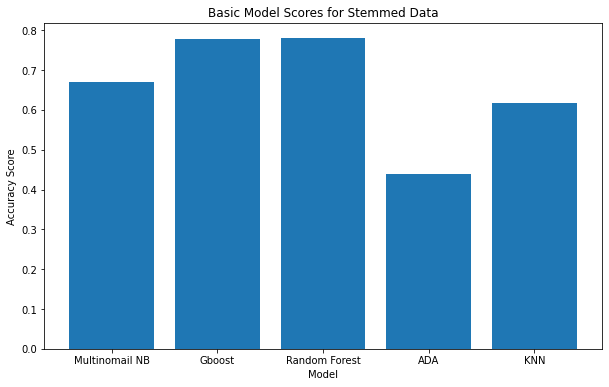

In [12]:
models_stem = [item[0] for item in basic_scores]
accuracy_stem = [item[1] for item in basic_scores]

plt.figure(figsize=(10,6))
plt.title("Basic Model Scores for Stemmed Data")
plt.xlabel("Model")
plt.ylabel("Accuracy Score")
plt.bar(models_stem, accuracy_stem)

In [13]:
lemmed_desc = clean_docs_lemma(desc_list)
len(set(nltk.word_tokenize(" ".join(lemmed_desc))))

2587

In [14]:
X = lemmed_desc
y = f_df['CardType']

len(X) == len(y)

True

In [15]:
from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(lemmed_desc, f_df['CardType'], test_size=0.2, 
                                                    random_state=18)

In [16]:
pipe_NB = Pipeline([('count_vectorizer', CountVectorizer()),
                    ('tfidf_vectorizer', TfidfTransformer()),
                    ('clf', MultinomialNB())
                    ])

pipe_GBoost = Pipeline([('count_vectorizer', CountVectorizer()), 
                    ('tfidf_vectorizer', TfidfTransformer()),
                    ('clf', GradientBoostingClassifier(learning_rate=0.3))
                    ])

pipe_RF = Pipeline([('count_vectorizer', CountVectorizer()), 
                    ('tfidf_vectorizer', TfidfTransformer()),
                    ('clf', RandomForestClassifier())
                    ])

pipe_ADA = Pipeline([('count_vectorizer', CountVectorizer()), 
                    ('tfidf_vectorizer', TfidfTransformer()),
                    ('clf', AdaBoostClassifier(learning_rate=0.3))
                    ])


pipe_KNN = Pipeline([('count_vectorizer', CountVectorizer()), 
                    ('tfidf_vectorizer', TfidfTransformer()),
                    ('clf', KNeighborsClassifier())
                    ])

pipelines = [pipe_NB, pipe_GBoost, pipe_RF, pipe_ADA, pipe_KNN]
pipeline_names = ['Multinomail NB', "Gboost", 'Random Forest', 'ADA', "KNN"]

for pipe in pipelines:
  print(pipe)
  pipe.fit(X_train, y_train)

lem_basic_scores = []
for index, val in enumerate(pipelines):
  tup = (pipeline_names[index], val.score(X_test, y_test))
  lem_basic_scores.append(tup)
  print('%s pipeline test accuracy: %.3f' % (pipeline_names[index], val.score(X_test, y_test)))

Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('tfidf_vectorizer', TfidfTransformer()),
                ('clf', MultinomialNB())])
Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('tfidf_vectorizer', TfidfTransformer()),
                ('clf', GradientBoostingClassifier(learning_rate=0.3))])
Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('tfidf_vectorizer', TfidfTransformer()),
                ('clf', RandomForestClassifier())])
Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('tfidf_vectorizer', TfidfTransformer()),
                ('clf', AdaBoostClassifier(learning_rate=0.3))])
Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('tfidf_vectorizer', TfidfTransformer()),
                ('clf', KNeighborsClassifier())])
Multinomail NB pipeline test accuracy: 0.662
Gboost pipeline test accuracy: 0.775
Random Forest pipeline test accuracy: 0.765
ADA pipeline tes

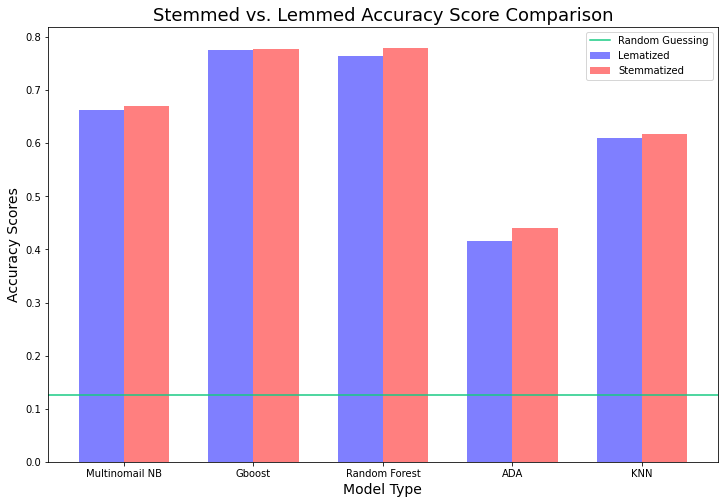

In [17]:
modles_lem = [item[0] for item in lem_basic_scores]
accuracy_lem = [item[1] for item in lem_basic_scores]


import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import namedtuple


n_groups = 5

means_men = (20, 35, 30, 35, 27)
std_men = (2, 3, 4, 1, 2)

means_women = (25, 32, 34, 20, 25)
std_women = (3, 5, 2, 3, 3)


fig, ax = plt.subplots(figsize = (12, 8))


index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.5
error_config = {'ecolor': '0.3'}

lemmed_bars = ax.bar(index, accuracy_lem, bar_width,
                alpha=opacity, color='b',
                label='Lematized')

stemmed_bars = ax.bar(index + bar_width, accuracy_stem, bar_width,
                alpha=opacity, color='r',
                label='Stemmatized')

ax.set_xlabel('Model Type', fontsize = 14)
ax.set_ylabel('Accuracy Scores', fontsize = 14)
ax.set_title('Stemmed vs. Lemmed Accuracy Score Comparison', fontsize = 18)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(modles_lem)

plt.axhline(y=1/len(set(y)), color='#17CA83', linestyle='-', label = "Random Guessing")
ax.legend()


plt.show()

In [18]:
tfidf = TfidfVectorizer()
response = tfidf.fit_transform(lemmed_desc)

PCA_df = pd.DataFrame(response.toarray(), columns=tfidf.get_feature_names())
PCA_df.shape

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(2000, 2573)

In [19]:
DATA = response  # this comes from above where you're vectorizing tdif dictionary

non_zero_cols = DATA.nnz / float(DATA.shape[0])
print("Average Number of Non-Zero Elements in Vectorized Articles: {}".format(non_zero_cols))

percent_sparse = 1 - (non_zero_cols / float(DATA.shape[1]))
print('Percentage of columns containing 0: {}'.format(percent_sparse))

Average Number of Non-Zero Elements in Vectorized Articles: 19.201
Percentage of columns containing 0: 0.9925375048581423


In [20]:
PCA_df.head()

,ability,ablaze,able,abomination,absolute,absolutely,abundant,abyss,abyssalacia,abyssleed,...,zera,zero,zerrziel,zhang,zing,zombie,zombyra,zone,zoodiac,zw
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.518826,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.157894,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.546837,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.110946,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.650907,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [21]:
X_pca = PCA_df
y_pca = f_df['CardType']

len(X_pca) == len(y_pca)

True

In [22]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_pca, test_size=0.2, random_state=18) 

In [23]:
from sklearn.decomposition import PCA
pca_1 = PCA(n_components=500)
pca_2 = PCA(n_components=1000)
pca_3 = PCA(n_components=1300)
pca_4 = PCA(n_components=1700)

principalComponents = pca_1.fit_transform(X_pca)
principalComponents = pca_2.fit_transform(X_pca)
principalComponents = pca_3.fit_transform(X_pca)
principalComponents = pca_4.fit_transform(X_pca)

print(np.sum(pca_1.explained_variance_ratio_))
print(np.sum(pca_2.explained_variance_ratio_))
print(np.sum(pca_3.explained_variance_ratio_))
print(np.sum(pca_4.explained_variance_ratio_))

0.8655763593236803
0.9816212225727512
0.9976880472339972
1.0


Takes a long time

In [24]:
# pipe_NB_pca = Pipeline([('pca', PCA(n_components=1300, random_state=18)),
#                      ('clf', GaussianNB())
#                     ])

# pipe_RF_pca = Pipeline([('pca', PCA(n_components=1300, random_state=18)),
#                      ('clf', RandomForestClassifier(n_jobs = -1))
#                    ])
                  
# pipe_GBoost_pca = Pipeline([('pca', PCA(n_components=1300, random_state=18)),
#                      ('clf', GradientBoostingClassifier(learning_rate=0.3))
#                     ])


# # List of pipelines, List of pipeline names
# pipelines = [pipe_NB_pca, pipe_RF_pca, pipe_GBoost_pca]
# pipeline_names = ['Multinomial NB', "Random Forest", "Gradient Boost"]

# # Loop to fit each of the three pipelines
# for pipe in pipelines:
#     print(pipe)
#     pipe.fit(X_train_pca, y_train_pca)

# # Compare accuracies
# PCA_scores = []
#  
# for index, val in enumerate(pipelines):
#     tup = (pipeline_names[index], val.score(X_test_pca, y_test_pca))
#     lem_basic_scores.append(tup)
#     print('%s pipeline test accuracy: %.3f' % (pipeline_names[index], val.score(X_test_pca, y_test_pca)))


In [48]:
PCA1300_results = dict(Multinomail_NB = 0.307,
Gradient_boost = 0.662,
Random_forest =0.690)

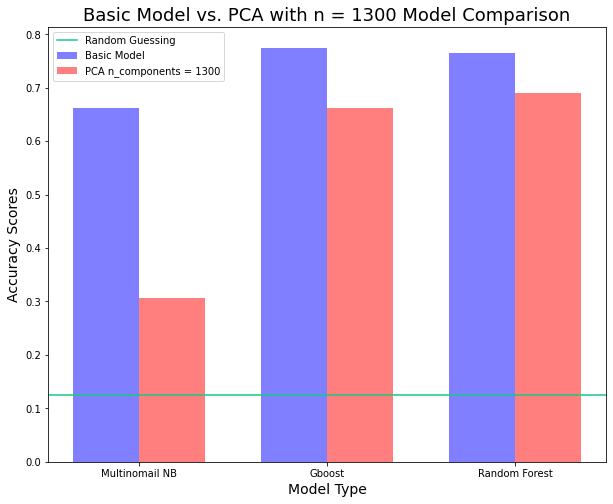

In [49]:
n_groups = 3

basic_mod_name = modles_lem[:3]
basic_mod_acc = accuracy_lem[:3]
pca_models_acc = [item[1] for item in PCA1300_results.items()]

fig, ax = plt.subplots(figsize = (10,8))


index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.5
error_config = {'ecolor': '0.3'}

basic_bars = ax.bar(index, basic_mod_acc, bar_width,
                alpha=opacity, color='b',
                label='Basic Model')

pca_bars = ax.bar(index + bar_width, pca_models_acc , bar_width,
                alpha=opacity, color='r',
                label='PCA n_components = 1300')

ax.set_xlabel('Model Type', fontsize = 14)
ax.set_ylabel('Accuracy Scores', fontsize = 14)
ax.set_title('Basic Model vs. PCA with n = 1300 Model Comparison', fontsize = 18)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(basic_mod_name)

plt.axhline(y=1/len(set(y)), color='#17CA83', linestyle='-', label = "Random Guessing")
ax.legend()
plt.show()

In [27]:
Top3_pipelines = [pipe_NB, pipe_GBoost, pipe_RF]
Top3_pipeline_names = ['Multinomail NB', "Gboost", 'Random Forest']

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

GS_pipe_RF = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', RandomForestClassifier())
                    ])

sorted(GS_pipe_RF.get_params().keys())

rf_param_grid = dict(clf__n_estimators = [10, 30, 100], clf__criterion = ['gini', 'entropy'], 
                    clf__max_depth = [2, 6, 10], clf__min_samples_split = [5, 10],
                    clf__min_samples_leaf = [3, 6])


gs_RF = GridSearchCV(estimator=GS_pipe_RF,
            param_grid=rf_param_grid,
            scoring='accuracy',
            cv=3,
            return_train_score=True)

grid_result = gs_RF.fit(X_train, y_train)

dt_gs_testing_score = gs_RF.score(X_test, y_test)

print("Mean Testing Score: {:.4}%".format(dt_gs_testing_score * 100))
print("Best Parameter Combination Found During Grid Search: {}".format(gs_RF.best_params_))

gs_RF_predictions = gs_RF.predict(X_test) 
  
#print classification report 
print(classification_report(y_test, gs_RF_predictions)) 

Mean Testing Score: 70.5%
Best Parameter Combination Found During Grid Search: {'clf__criterion': 'entropy', 'clf__max_depth': 10, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 5, 'clf__n_estimators': 100}
                 precision    recall  f1-score   support

 Effect Monster       0.52      0.34      0.41        47
 Fusion Monster       0.73      0.54      0.62        41
   Link Monster       0.63      0.88      0.73        50
 Normal Monster       0.61      0.96      0.74        48
          Spell       0.63      0.33      0.43        52
Synchro Monster       0.94      1.00      0.97        66
           Trap       0.52      0.47      0.49        47
    XYZ Monster       0.91      1.00      0.95        49

       accuracy                           0.70       400
      macro avg       0.69      0.69      0.67       400
   weighted avg       0.70      0.70      0.68       400



In [29]:
Grid_RF_metrics = dict(test_score = dt_gs_testing_score, best_params = gs_RF.best_params_)
Grid_RF_metrics

{'test_score': 0.705,
 'best_params': {'clf__criterion': 'entropy',
  'clf__max_depth': 10,
  'clf__min_samples_leaf': 3,
  'clf__min_samples_split': 5,
  'clf__n_estimators': 100}}

In [30]:
GS_pipe_GB = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', GradientBoostingClassifier())
                    ])
# sorted(GS_pipe_RF.get_params().keys())

GB_params = {
    "clf__learning_rate": [0.2, 0.25],
    "clf__min_samples_split": [4, 5],
    "clf__min_samples_leaf": [6],
    "clf__max_depth":[3],
    "clf__n_estimators":[100, 150]
    }

gs_GB = GridSearchCV(estimator=GS_pipe_GB,
            param_grid=GB_params,
            scoring='accuracy',
            cv=3)

gs_GB.fit(X_train, y_train)

dt_GB_testing_score = gs_GB.score(X_test, y_test)
print("Mean Testing Score: {:.4}%".format(dt_GB_testing_score * 100))
print("Best Parameter Combination Found During Grid Search: {}".format(gs_GB.best_params_))

gs_GB_predictions = gs_GB.predict(X_test) 
  
#print classification report 
print(classification_report(y_test, gs_GB_predictions)) 

Mean Testing Score: 76.5%
Best Parameter Combination Found During Grid Search: {'clf__learning_rate': 0.25, 'clf__max_depth': 3, 'clf__min_samples_leaf': 6, 'clf__min_samples_split': 4, 'clf__n_estimators': 150}
                 precision    recall  f1-score   support

 Effect Monster       0.59      0.51      0.55        47
 Fusion Monster       0.71      0.66      0.68        41
   Link Monster       0.88      0.90      0.89        50
 Normal Monster       0.91      0.90      0.91        48
          Spell       0.50      0.50      0.50        52
Synchro Monster       1.00      1.00      1.00        66
           Trap       0.49      0.57      0.53        47
    XYZ Monster       0.96      0.98      0.97        49

       accuracy                           0.77       400
      macro avg       0.76      0.75      0.75       400
   weighted avg       0.77      0.77      0.77       400



In [31]:
Grid_GB_metrics = dict(test_score = dt_GB_testing_score, best_params = gs_GB.best_params_)
Grid_GB_metrics

{'test_score': 0.765,
 'best_params': {'clf__learning_rate': 0.25,
  'clf__max_depth': 3,
  'clf__min_samples_leaf': 6,
  'clf__min_samples_split': 4,
  'clf__n_estimators': 150}}

In [32]:
def test_type(desc):
  lemmed_test = clean_docs_lemma(desc)
  print("This card is a {} card!".format(gs_RF.predict(lemmed_test)[0]))

In [33]:
effectmon_desc = ["""When this card is Normal Summoned: You can target 1 Level 2 or lower monster in your Graveyard; Special Summon that target in Defense Position, but it has its effects negated."""]

fusmon_desc = [""""Elemental HERO Avian" + "Elemental HERO Burstinatrix" Must be Fusion Summoned and cannot be Special Summoned by other ways. When this card destroys a monster by battle and sends it to the Graveyard: Inflict damage to your opponent equal to the ATK of the destroyed monster in the Graveyard."""]

linkmon_desc = ["""3+ Effect Monsters Cannot be destroyed by battle. Once per turn (Quick Effect): You can target 1 Attack Position monster; change it to Defense Position, also, this card can make a second attack during each Battle Phase this turn. Your opponent cannot activate cards or effects in response to this effect's activation. Once per turn, when this card declares an attack on a face-up monster: You can activate this effect; until the end of this turn, this card gains ATK equal to half that monster's current ATK, and if it does, that monster's current ATK is halved."""]

normmon_desc = ["""Everyone is full of possibilities. Everything you do, moving forwards, stopping, closing, opening, is all in your hands.There are many doors in this world. To open them requires the Magic Key... 2 keys and 1 door... 2 wills and 1 body. Once the doors are opened, the worlds will be connected and the great power revealed."""]

synchmon_desc = ["""1 Tuner + 1+ non-Tuner monsters If this card is Synchro Summoned: You can banish 1 Level 6 or lower Fish monster from your Deck. If this card is sent to the GY as Synchro Material: You can target 1 Fish monster in your GY; banish that target, then you can add 1 Fish monster with an equal or lower Level from your Deck to your hand. You can only use each effect of "Arionpos, Serpent of the Ghoti" once per turn."""]

spell_desc = ["""Add 1 Level 4 or lower Warrior monster from your Deck to your hand."""]

trap_desc = ["""When a monster(s) would be Special Summoned, OR a monster effect is activated: Pay 1500 LP; negate the Summon or activation, and if you do, destroy that card."""]

token_desc = ["""Special Summoned with the effect of "Dragonecro Nethersoul Dragon"."""]

pog_desc = ["""Draw 2 cards."""]

In [34]:
test_type(effectmon_desc)
test_type(fusmon_desc)
test_type(linkmon_desc)
test_type(normmon_desc)
test_type(synchmon_desc)
test_type(spell_desc)
test_type(trap_desc)
test_type(token_desc)
test_type(pog_desc)

clean_docs_lemma(effectmon_desc)

This card is a Effect Monster card!
This card is a Fusion Monster card!
This card is a Link Monster card!
This card is a Normal Monster card!
This card is a Synchro Monster card!
This card is a Normal Monster card!
This card is a Trap card!
This card is a Normal Monster card!
This card is a Normal Monster card!


['card normal summoned target level lower monster graveyard special summon target defense position effect negated']

In [50]:
example1 = ["""2 Level 12 monsters Once per turn, if an Xyz Monster battled this turn, you can also Xyz Summon "Divine Arsenal AA-ZEUS - Sky Thunder" by using 1 Xyz Monster you control as material. (Transfer its materials to this card.) (Quick Effect): You can detach 2 materials from this card; send all other cards from the field to the GY. Once per turn, if another card(s) you control is destroyed by battle or an opponent's card effect: You can attach 1 card from your hand, Deck, or Extra Deck to this card as material."""]
example2 = ["""During the Main Phase, if your opponent Normal or Special Summoned 5 or more monsters this turn (Quick Effect): You can Tribute as many face-up monsters on the field as possible, and if you do, Special Summon this card from your hand, then Special Summon 1 "Primal Being Token" (Rock/LIGHT/Level 11/ATK ?/DEF ?) to your opponent's field. (This Token's ATK/DEF become the combined original ATK/DEF of the Tributed monsters.) You can only use this effect of "Nibiru, the Primal Being" once per turn."""]
example3 = ["""Pay 1000 LP; Special Summon 1 Level 5 or lower Fusion Monster from your Extra Deck, but it cannot attack, also it is destroyed during the End Phase. (This is treated as a Fusion Summon.) You can only activate 1 "Instant Fusion" per turn."""]
example4 = ["""Requires 3 Tributes to Normal Summon (cannot be Normal Set). This card's Normal Summon cannot be negated. When Normal Summoned, cards and effects cannot be activated. Cannot be targeted by Spells, Traps, or card effects. Once per turn, during the End Phase, if this card was Special Summoned: Send it to the Graveyard. You can Tribute 2 monsters; destroy all monsters your opponent controls. This card cannot declare an attack the turn this effect is activated."""]
test_type(example1)
test_type(example2)
test_type(example3)
test_type(example4)

This card is a XYZ Monster card!
This card is a Link Monster card!
This card is a Spell card!
This card is a Effect Monster card!


In [36]:
final_top3 = [("GradientBoost with GridSearch", Grid_GB_metrics['test_score']), 
              basic_scores[0], ("Random Forest with GridSearch", basic_scores[2][1])]

final_top3

[('GradientBoost with GridSearch', 0.765),
 ('Multinomail NB', 0.67),
 ('Random Forest with GridSearch', 0.78)]

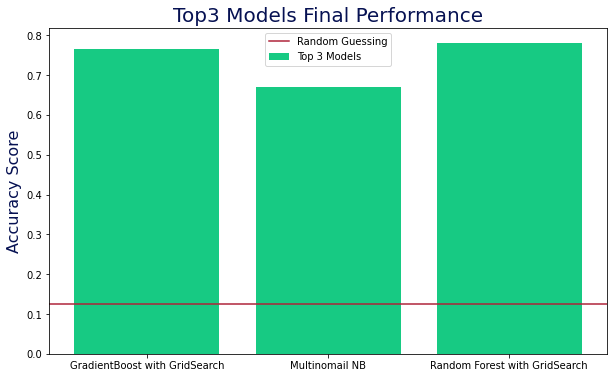

In [37]:
top3_model = [item[0] for item in final_top3]
top3_scores = [item[1] for item in final_top3]

plt.figure(figsize=(10,6))
plt.title("Top3 Models Final Performance", color ='#061152' , fontsize = 20)
plt.ylabel("Accuracy Score", color = '#061152', fontsize = 16)
plt.bar(top3_model, top3_scores, color = "#17CA83", label = "Top 3 Models")

plt.axhline(y=1/len(set(y)), color='#AF2138', linestyle='-', label = "Random Guessing")
plt.legend()

plt.show()

In [38]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models

In [39]:
len(lemmed_desc)

2000

In [40]:
import random
test = random.sample(lemmed_desc, 1700)
lemmed_lyr = [nltk.word_tokenize(doc) for doc in test]

lemmed_lyr
# test
dictionary = gensim.corpora.Dictionary(lemmed_lyr)

count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

bow_corpus = [dictionary.doc2bow(doc) for doc in lemmed_lyr]

0 activate
1 card
2 control
3 destroy
4 detach
5 effect
6 face
7 field
8 level
9 material
10 monster


In [41]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=15, id2word=dictionary, passes=2, workers=2)
for idx, topic in lda_model.print_topics(-1):
  print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.057*"spell" + 0.050*"dark" + 0.047*"hero" + 0.037*"summoned" + 0.034*"elemental" + 0.031*"special" + 0.030*"magician" + 0.025*"hand" + 0.023*"creature" + 0.021*"opponent"
Topic: 1 
Words: 0.059*"level" + 0.052*"special" + 0.041*"summon" + 0.036*"atk" + 0.035*"summoned" + 0.029*"effect" + 0.027*"not" + 0.025*"can" + 0.022*"per" + 0.019*"hero"
Topic: 2 
Words: 0.067*"hand" + 0.048*"'s" + 0.041*"effect" + 0.037*"gy" + 0.037*"destroyed" + 0.029*"wind" + 0.027*"add" + 0.025*"opponent" + 0.025*"deck" + 0.023*"discard"
Topic: 3 
Words: 0.046*"'s" + 0.045*"synchro" + 0.038*"graveyard" + 0.036*"type" + 0.036*"effect" + 0.034*"summoned" + 0.026*"dark" + 0.025*"field" + 0.024*"opponent" + 0.020*"can"
Topic: 4 
Words: 0.051*"target" + 0.042*"warrior" + 0.032*"control" + 0.032*"special" + 0.029*"atk" + 0.029*"field" + 0.026*"fire" + 0.026*"summon" + 0.024*"effect" + 0.023*"summoned"
Topic: 5 
Words: 0.085*"deck" + 0.050*"hand" + 0.038*"graveyard" + 0.033*"per" + 0.031*"effect" + 

In [42]:
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=15, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.047*"creature" + 0.035*"attack" + 0.030*"enemy" + 0.027*"fairy" + 0.021*"dark" + 0.021*"negate" + 0.020*"effect" + 0.020*"gy" + 0.017*"soul" + 0.016*"sea"
Topic: 1 Word: 0.040*"tuner" + 0.032*"synchro" + 0.020*"water" + 0.019*"non" + 0.018*"earth" + 0.018*"gy" + 0.017*"summoned" + 0.016*"summon" + 0.016*"special" + 0.016*"control"
Topic: 2 Word: 0.028*"spell" + 0.023*"trap" + 0.021*"tuner" + 0.020*"destroy" + 0.020*"pendulum" + 0.019*"effect" + 0.019*"zone" + 0.018*"activation" + 0.017*"activated" + 0.017*"negate"
Topic: 3 Word: 0.040*"attack" + 0.022*"material" + 0.021*"activate" + 0.021*"xyz" + 0.020*"face" + 0.019*"level" + 0.019*"red" + 0.019*"field" + 0.018*"position" + 0.015*"special"
Topic: 4 Word: 0.043*"xyz" + 0.037*"material" + 0.027*"'s" + 0.026*"detach" + 0.022*"beast" + 0.020*"level" + 0.018*"deck" + 0.016*"effect" + 0.016*"face" + 0.015*"field"
Topic: 5 Word: 0.046*"dragon" + 0.029*"enemy" + 0.021*"battle" + 0.020*"damage" + 0.018*"attack" + 0.018*"tuner"

In [43]:
weights = tfidf[bow_corpus[12]]

# Get terms from the dictionary and pair with weights

weights = [(dictionary[pair[0]], pair[1]) for pair in weights]
weights[-35:]

[('level', 0.14940499168537608),
 ('opponent', 0.08537816615299872),
 ('special', 0.10349702055236747),
 ('summon', 0.11229354971969367),
 ('atk', 0.1365470061009296),
 ('def', 0.26171943327007424),
 ('gy', 0.17054391039978592),
 ('negate', 0.26606761018289865),
 ('attack', 0.48852175073713827),
 ('earth', 0.40753332561599565),
 ('position', 0.22175145363300816),
 ('declares', 0.38771680885349846),
 ('token', 0.39473149602729657)]

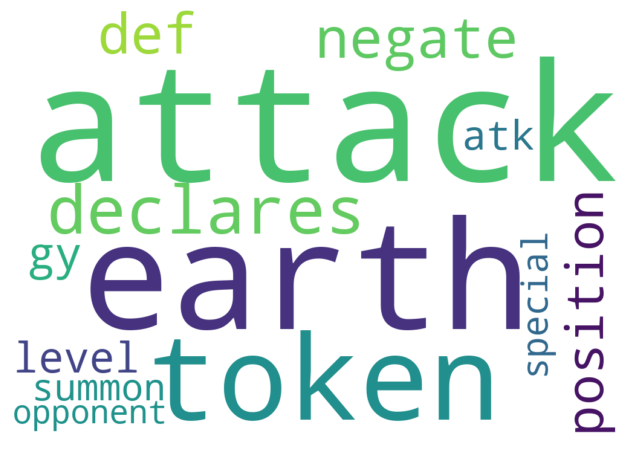

In [44]:
# !pip install wordcloud
from wordcloud import WordCloud

# Initialize the word cloud

d = {}
for a, x in weights:
    d[a] = x
    
wc = WordCloud(
    background_color="white",
    max_words=2000,
    width = 1024,
    height = 720,
    stopwords=stopwords.words("english")
)

# Generate the cloud

wc.generate_from_frequencies(d)
plt.figure(figsize = (12, 8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [45]:
d

{'level': 0.14940499168537608,
 'opponent': 0.08537816615299872,
 'special': 0.10349702055236747,
 'summon': 0.11229354971969367,
 'atk': 0.1365470061009296,
 'def': 0.26171943327007424,
 'gy': 0.17054391039978592,
 'negate': 0.26606761018289865,
 'attack': 0.48852175073713827,
 'earth': 0.40753332561599565,
 'position': 0.22175145363300816,
 'declares': 0.38771680885349846,
 'token': 0.39473149602729657}

In [46]:

#https://towardsdatascience.com/music-genre-classification-with-python-c714d032f0d8